In [2]:
# Import relevant stuff
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Goes from a list stored in a df to just the value inside.
def fix_list_format(df, col_title):
    fixed_row = []
    for index, row in df.iterrows():
        str1 = row[col_title]
        if len(str1) > 2:
            fixed_row.append(row[col_title][1:-1])
        else:
            fixed_row.append(np.nan)
    df[col_title] = fixed_row

In [4]:
# Load mp-stable matches (2.1k)
df0 = pd.read_excel("C:/Users/Droor/OneDrive - Harvard University/Desktop/Master Folder/College (2022-2026)/Hoffman summer/git-clone/superconductors-ml/datasets/only_stable_mp_matches.xlsx")
df0 = df0.drop('material_dict_queried', axis=1)
df0['material_dict'] = df0['material_dict'].apply(literal_eval) #convert to list type
fix_list_format(df0, 'unit_cell_volumes')
df0_normalized = pd.json_normalize(df0['material_dict'])
df0_exploded = pd.concat([df0, df0_normalized], axis=1)
df0_exploded.head()

,sc_id,supercon_formula,cleaned_formula,material_dict,highest_Tc,average_Tc,std_Tc,entry_count,matches_by_element,matches_by_dict,...,Dy,Er,Ho,Tm,Br,Nd,Hg,Cl,Tc,Mn
0,[18852],Ag1B2,Ag1B2,"{'Ag': 1.0, 'B': 2.0}",6.7,6.7,0.0,1,[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[20016],Ag1Ba2Ca2Cu3O9-z,Ag1Ba2Ca2Cu3O9,"{'Ag': 1.0, 'Ba': 2.0, 'Ca': 2.0, 'Cu': 3.0, '...",110,110.0,0.0,1,[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[20017],Ag1Ba2Ca3Cu4O11-z,Ag1Ba2Ca3Cu4O11,"{'Ag': 1.0, 'Ba': 2.0, 'Ca': 3.0, 'Cu': 4.0, '...",117,117.0,0.0,1,[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[20018],Ag1Ba2Ca4Cu5O13-z,Ag1Ba2Ca4Cu5O13,"{'Ag': 1.0, 'Ba': 2.0, 'Ca': 4.0, 'Cu': 5.0, '...",105,105.0,0.0,1,[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[20019],Ag1Ba2Ca5Cu6O15-z,Ag1Ba2Ca5Cu6O15,"{'Ag': 1.0, 'Ba': 2.0, 'Ca': 5.0, 'Cu': 6.0, '...",80,80.0,0.0,1,[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Load all non-doped unique materials (14k)
df2 = pd.read_json("C:/Users/Droor/OneDrive - Harvard University/Desktop/Master Folder/College (2022-2026)/Hoffman summer/git-clone/superconductors-ml/datasets/unique_materials_14k.json")

df2_normalized = pd.json_normalize(df2['material_dict'])
df2_exploded = pd.concat([df2, df2_normalized], axis=1)

In [28]:
# Load element-data
# !!! I manually changed La and Ce atomic radius to be the 2008 covalent radius value! (https://webelements.com/cerium/atom_sizes.html)
element_data = pd.read_excel("C:/Users/Droor/OneDrive - Harvard University/Desktop/Master Folder/College (2022-2026)/Hoffman summer/git-clone/superconductors-ml/datasets/element_data_fixed.xlsx", header=1)
element_data = element_data.drop("Unnamed: 0", axis=1)
numeric_columns = element_data.select_dtypes(include=np.number).columns
element_data = element_data[[element_data.columns[0]] + list(numeric_columns)]


element_data_8_features = element_data.loc[:, ['Element', 'AtomicMass', 'FirstIonizationEnergy', 'AtomicRadius', 'Density', 'ElectronAffinity', 'FusionHeat', 'ThermalConductivity', 'Valence']]
# ADD 1.5 to all ElectronAffinity values to make them all positive
element_data_8_features['ElectronAffinity'] = element_data_8_features['ElectronAffinity'] + 1.5

element_data_8_features.to_excel('elem12.xlsx')

#### **Hamidieh-style model using element data**

In [46]:
# Choose the dataframe to use for generating features.
df_used = df2_exploded
df_used.head()

,sc_id,supercon_formula,cleaned_formula,material_dict,highest_Tc,average_Tc,std_Tc,entry_count,Ag,Al,...,Sm,Dy,Ir,K,Rb,Cs,Tm,Br,Cl,Tc
0,[12787],Ag0.002Al0.998,Ag0.002Al0.998,"{'Ag': 0.002, 'Al': 0.998}",1.128,1.128,0.0,1,0.002,0.998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[12816],Ag0.005Zn0.995,Ag0.005Zn0.995,"{'Ag': 0.005, 'Zn': 0.995}",0.763,0.763,0.0,1,0.005,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[25145],Bi3.99Ag0.01S3O4,Bi3.99Ag0.01S3O4,"{'Ag': 0.01, 'Bi': 3.99, 'O': 4.0, 'S': 3.0}",4.310,4.310,0.0,1,0.010,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[23179],Sr1Pd1.98Ag0.02Ge2,Sr1Pd1.98Ag0.02Ge2,"{'Ag': 0.02, 'Ge': 2.0, 'Pd': 1.98, 'Sr': 1.0}",2.640,2.640,0.0,1,0.020,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[25146],Bi3.97Ag0.03S3O4,Bi3.97Ag0.03S3O4,"{'Ag': 0.03, 'Bi': 3.9699999999999998, 'O': 4....",4.200,4.200,0.0,1,0.030,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
from numpy.ma.core import mean
from scipy.stats import gmean, entropy
from statsmodels.stats.weightstats import DescrStatsW

# We are going to create a 3D space (np array) with coordinates (feature, property, material_name)

data = np.empty((len(df_used), 8, 10), dtype=object)
data.fill(None)

# Get the total number of atoms in all materials
df_elements = df_used.iloc[:, 8:]
n_atoms = np.nansum(df_elements, axis=1)
df_elements_normed = df_elements.div(n_atoms, axis=0)


# Iterate over every *material*
for material_index in range(len(df_used)):
   
    p_array = np.array(df_elements_normed.iloc[material_index].dropna().values)
    # Iterate over every *property*
    for property_index, property_name in enumerate(element_data_8_features.columns[1:9]):

        # intermediate
        index_list = df_elements.iloc[material_index].dropna().index.tolist()
        
        t_list = element_data_8_features[element_data_8_features['Element'].isin(index_list)].set_index('Element').loc[index_list, property_name].tolist()
        w_list = t_list / np.sum(t_list)
        capital_list = p_array * w_list / np.sum(p_array * w_list)

        # Add into our *3D-magic-thing* this coordinate.
        data[material_index, property_index, 0] = np.mean(t_list)
        data[material_index, property_index, 1] = np.average(t_list, weights=p_array)
        data[material_index, property_index, 2] = gmean(t_list)
        data[material_index, property_index, 3] = gmean(t_list, weights=p_array)
        data[material_index, property_index, 4] = entropy(w_list)
        data[material_index, property_index, 5] = entropy(capital_list)
        data[material_index, property_index, 6] = np.ptp(t_list)
        data[material_index, property_index, 7] = np.ptp(np.multiply(t_list, p_array))
        data[material_index, property_index, 8] = np.std(t_list)
        data[material_index, property_index, 9] = DescrStatsW(t_list, weights=p_array).std


In [48]:
# This creates a dataframe 'updated_df' from the features we just calcualted.
# STEPS to go from 3d and collapse down to 2d to get all features of a property (10*30 = 300 features total)

# Step 1: Create column names for the features
column_names = ['mean', 'weighted_mean', 'geom_mean', 'weighted_geom_mean',
                'entropy', 'weighted_entropy', 'range', 'weighted_range', 'std', 'weighted_std']

# Step 2: Create an empty dictionary
new_columns = {}

# Step 3: Iterate over each material
for material_index, row in df_used.iterrows():

  # Step 4: Iterate over each property
  for property_index, property_name in enumerate(element_data_8_features.columns[1:9]):

    # Step 5: Iterate over each feature index
    for feature_index in range(10):

      # Step 6: Retrieve the feature value
      feature_value = data[material_index][property_index][feature_index]

      # Step 7: Assign the feature value to the dictionary with unique column name
      column_name = f'{property_name}_{column_names[feature_index]}'
      new_columns.setdefault(column_name, []).append(feature_value)

# Step 8: Create a DataFrame from the dictionary
new_columns_df = pd.DataFrame(new_columns)

# Step 9: Merge the new DataFrame with df_used
updated_df = pd.merge(df_used, new_columns_df, left_index=True, right_index=True)
updated_df.head(100)

,sc_id,supercon_formula,cleaned_formula,material_dict,highest_Tc,average_Tc,std_Tc,entry_count,Ag,Al,...,Valence_mean,Valence_weighted_mean,Valence_geom_mean,Valence_weighted_geom_mean,Valence_entropy,Valence_weighted_entropy,Valence_range,Valence_weighted_range,Valence_std,Valence_weighted_std
0,[12787],Ag0.002Al0.998,Ag0.002Al0.998,"{'Ag': 0.002, 'Al': 0.998}",1.128,1.128,0.000000,1,0.002,0.998,...,2.000000,2.996000,1.732051,2.993416,0.562335,0.005548,2,2.992000,1.000000,0.089353
1,[12816],Ag0.005Zn0.995,Ag0.005Zn0.995,"{'Ag': 0.005, 'Zn': 0.995}",0.763,0.763,0.000000,1,0.005,NaN,...,1.500000,1.995000,1.414214,1.993081,0.636514,0.017513,1,1.985000,0.500000,0.070534
2,[25145],Bi3.99Ag0.01S3O4,Bi3.99Ag0.01S3O4,"{'Ag': 0.01, 'Bi': 3.99, 'O': 4.0, 'S': 3.0}",4.310,4.310,0.000000,1,0.010,NaN,...,3.500000,4.178182,2.783158,3.760313,1.197340,1.035537,5,1.812727,2.061553,1.698415
3,[23179],Sr1Pd1.98Ag0.02Ge2,Sr1Pd1.98Ag0.02Ge2,"{'Ag': 0.02, 'Ge': 2.0, 'Pd': 1.98, 'Sr': 1.0}",2.640,2.640,0.000000,1,0.020,NaN,...,2.750000,3.588000,2.378414,3.462946,1.263654,0.973256,3,1.596000,1.299038,0.816245
4,[25146],Bi3.97Ag0.03S3O4,Bi3.97Ag0.03S3O4,"{'Ag': 0.03, 'Bi': 3.9699999999999998, 'O': 4....",4.200,4.200,0.000000,1,0.030,NaN,...,3.500000,4.170909,2.783158,3.749326,1.197340,1.038913,5,1.801818,2.061553,1.703437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"[12808, 12809, 19136, 19246]",Ag1Mo4S5,Ag1Mo4S5,"{'Ag': 1.0, 'Mo': 4.0, 'S': 5.0}",8.300,7.885,0.241299,4,1.000,NaN,...,4.333333,5.500000,3.301927,5.015753,0.911018,0.765347,5,2.900000,2.357023,1.500000
96,"[15777, 19112]",Ag1Mo6S8,Ag1Mo6S8,"{'Ag': 1.0, 'Mo': 6.0, 'S': 8.0}",7.700,7.700,0.000000,2,1.000,NaN,...,4.333333,5.666667,3.301927,5.324447,0.911018,0.738836,5,3.133333,2.357023,1.247219
97,[12805],Ag1Nb3,Ag1Nb3,"{'Ag': 1.0, 'Nb': 3.0}",8.280,8.280,0.000000,1,1.000,NaN,...,3.000000,4.000000,2.236068,3.343702,0.450561,0.233792,4,3.500000,2.000000,1.732051
98,[16573],Ag1Sn1Se1.8S0.2,Ag1Sn1Se1.8S0.2,"{'Ag': 1.0, 'S': 0.2, 'Se': 1.8, 'Sn': 1.0}",5.790,5.790,0.000000,1,1.000,NaN,...,4.250000,4.250000,3.464102,3.464102,1.242255,0.982445,5,2.450000,2.046338,2.046338


In [ ]:
# # Save your dataframe
# updated_df.to_json('df_nondoped_materials_wfeatures.json')
# updated_df.to_excel('df_nondoped_materials_wfeatures.xlsx')

Load .json with features already generated:

In [ ]:
# # Uncomment based on what you want to do.
# updated_df = pd.read_json("C:/Users/Droor/OneDrive - Harvard University/Desktop/Master Folder/College (2022-2026)/Hoffman summer/git-clone/superconductors-ml/datasets/df_unique_materials_wfeatures_v2.json")

In [49]:
updated_df_no_cuprates = updated_df[updated_df['Cu'].isna() & updated_df['O'].isna()]

In [50]:
updated_df_no_cuprates.head()

,sc_id,supercon_formula,cleaned_formula,material_dict,highest_Tc,average_Tc,std_Tc,entry_count,Ag,Al,...,Valence_mean,Valence_weighted_mean,Valence_geom_mean,Valence_weighted_geom_mean,Valence_entropy,Valence_weighted_entropy,Valence_range,Valence_weighted_range,Valence_std,Valence_weighted_std
0,[12787],Ag0.002Al0.998,Ag0.002Al0.998,"{'Ag': 0.002, 'Al': 0.998}",1.128,1.128,0.0,1,0.002,0.998,...,2.000000,2.996,1.732051,2.993416,0.562335,0.005548,2,2.992,1.000000,0.089353
1,[12816],Ag0.005Zn0.995,Ag0.005Zn0.995,"{'Ag': 0.005, 'Zn': 0.995}",0.763,0.763,0.0,1,0.005,NaN,...,1.500000,1.995,1.414214,1.993081,0.636514,0.017513,1,1.985,0.500000,0.070534
3,[23179],Sr1Pd1.98Ag0.02Ge2,Sr1Pd1.98Ag0.02Ge2,"{'Ag': 0.02, 'Ge': 2.0, 'Pd': 1.98, 'Sr': 1.0}",2.640,2.640,0.0,1,0.020,NaN,...,2.750000,3.588,2.378414,3.462946,1.263654,0.973256,3,1.596,1.299038,0.816245
5,[14866],Ag0.03Tl0.97,Ag0.03Tl0.97,"{'Ag': 0.03, 'Tl': 0.97}",2.670,2.670,0.0,1,0.030,NaN,...,2.000000,2.940,1.732051,2.902737,0.562335,0.056937,2,2.880,1.000000,0.341174
6,[12794],Ag0.035Cd0.01Sn0.955,Ag0.035Cd0.01Sn0.955,"{'Ag': 0.035, 'Cd': 0.01, 'Sn': 0.955000000000...",3.650,3.650,0.0,1,0.035,NaN,...,2.333333,3.875,2.000000,3.784231,0.955700,0.083789,3,3.800,1.247219,0.582559


Get information and redress missing element-data issues.

Run Models ( 8: is including stoichiometric information, 85: is starting at AtomicMass_mean)

In [93]:
df_for_model = updated_df
df_for_model.head(10)

,sc_id,supercon_formula,cleaned_formula,material_dict,highest_Tc,average_Tc,std_Tc,entry_count,Ag,Al,...,Valence_mean,Valence_weighted_mean,Valence_geom_mean,Valence_weighted_geom_mean,Valence_entropy,Valence_weighted_entropy,Valence_range,Valence_weighted_range,Valence_std,Valence_weighted_std
0,[12787],Ag0.002Al0.998,Ag0.002Al0.998,"{'Ag': 0.002, 'Al': 0.998}",1.128,1.128,0.0,1,0.002,0.998,...,2.000000,2.996000,1.732051,2.993416,0.562335,0.005548,2,2.992000,1.000000,0.089353
1,[12816],Ag0.005Zn0.995,Ag0.005Zn0.995,"{'Ag': 0.005, 'Zn': 0.995}",0.763,0.763,0.0,1,0.005,NaN,...,1.500000,1.995000,1.414214,1.993081,0.636514,0.017513,1,1.985000,0.500000,0.070534
2,[25145],Bi3.99Ag0.01S3O4,Bi3.99Ag0.01S3O4,"{'Ag': 0.01, 'Bi': 3.99, 'O': 4.0, 'S': 3.0}",4.310,4.310,0.0,1,0.010,NaN,...,3.500000,4.178182,2.783158,3.760313,1.197340,1.035537,5,1.812727,2.061553,1.698415
3,[23179],Sr1Pd1.98Ag0.02Ge2,Sr1Pd1.98Ag0.02Ge2,"{'Ag': 0.02, 'Ge': 2.0, 'Pd': 1.98, 'Sr': 1.0}",2.640,2.640,0.0,1,0.020,NaN,...,2.750000,3.588000,2.378414,3.462946,1.263654,0.973256,3,1.596000,1.299038,0.816245
4,[25146],Bi3.97Ag0.03S3O4,Bi3.97Ag0.03S3O4,"{'Ag': 0.03, 'Bi': 3.9699999999999998, 'O': 4....",4.200,4.200,0.0,1,0.030,NaN,...,3.500000,4.170909,2.783158,3.749326,1.197340,1.038913,5,1.801818,2.061553,1.703437
5,[14866],Ag0.03Tl0.97,Ag0.03Tl0.97,"{'Ag': 0.03, 'Tl': 0.97}",2.670,2.670,0.0,1,0.030,NaN,...,2.000000,2.940000,1.732051,2.902737,0.562335,0.056937,2,2.880000,1.000000,0.341174
6,[12794],Ag0.035Cd0.01Sn0.955,Ag0.035Cd0.01Sn0.955,"{'Ag': 0.035, 'Cd': 0.01, 'Sn': 0.955000000000...",3.650,3.650,0.0,1,0.035,NaN,...,2.333333,3.875000,2.000000,3.784231,0.955700,0.083789,3,3.800000,1.247219,0.582559
7,[13],Ba0.1La1.9Ag0.05Cu0.95O4-Y,Ba0.1La1.9Ag0.05Cu0.95O4,"{'Ag': 0.05, 'Ba': 0.1, 'Cu': 0.95000000000000...",27.000,27.000,0.0,1,0.050,NaN,...,2.000000,2.264286,1.888175,2.221652,1.557113,1.040517,2,1.135714,0.632456,0.456864
8,[25147],Bi3.95Ag0.05S3O4,Bi3.95Ag0.05S3O4,"{'Ag': 0.05, 'Bi': 3.95, 'O': 4.0, 'S': 3.0}",3.520,3.520,0.0,1,0.050,NaN,...,3.500000,4.163636,2.783158,3.738370,1.197340,1.041976,5,1.790909,2.061553,1.708414
9,[12802],Ag0.05Rh0.04Ti0.91,Ag0.05Rh0.04Ti0.91,"{'Ag': 0.05, 'Rh': 0.04, 'Ti': 0.91}",1.950,1.950,0.0,1,0.050,NaN,...,3.666667,3.930000,2.884499,3.793155,0.916465,0.297259,5,3.590000,2.054805,0.777882


In [94]:
X0 = df_for_model.iloc[:, [1,2,3,4] + list(range(8, df_for_model.shape[1]))].values
X1 = df_for_model.iloc[:, [1,2,3,4] + list(range(85, df_for_model.shape[1]))].values

In [53]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

def train_evaluate_regression_model(X, y, model, start_feature_index):

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)
    
    # Take only the features, not the ID columns
    X_train_2 = X_train[:, start_feature_index:]
    X_test_2 = X_test[:, start_feature_index:]

    # Train the model
    model.fit(X_train_2, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_2)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2, y_test, y_pred, model, X_train, X_test

In [54]:
# Step 1: Select the features and target variable
y = df_for_model['average_Tc'].values

X0 = df_for_model.iloc[:, [1, 2, 3, 4] + list(range(8, df_for_model.shape[1]))].values
X1 = df_for_model.iloc[:, [1, 2, 3, 4] + list(range(85, df_for_model.shape[1]))].values

XGB_stoichio_mse, XGB_stoichio_r2, XGB_stoichio_y_test, XGB_stoichio_y_pred, XGB_stoichio_model, XGB_stoichio_X_train, XGB_stoichio_X_test = train_evaluate_regression_model(X0, y, xgb.XGBRegressor(), 4)
XGB_nostoichio_mse, XGB_nostoichio_r2, XGB_nostoichio_y_test, XGB_nostoichio_y_pred, XGB_nostoichio_model, XGB_nostoichio_X_train, XGB_nostoichio_X_test = train_evaluate_regression_model(X1, y, xgb.XGBRegressor(), 4)

print("XGBoost Regression (with stoichio features):")
print("MSE:", XGB_stoichio_mse)
print("R2 Score:", XGB_stoichio_r2)

print("XGBoost Regression (without stoichio features):")
print("MSE:", XGB_nostoichio_mse)
print("R2 Score:", XGB_nostoichio_r2)


XGBoost Regression (with stoichio features):
MSE: 88.83948937408513
R2 Score: 0.9070908585496069
XGBoost Regression (without stoichio features):
MSE: 87.91271470991133
R2 Score: 0.9080600878751357


Some analysis of our model:

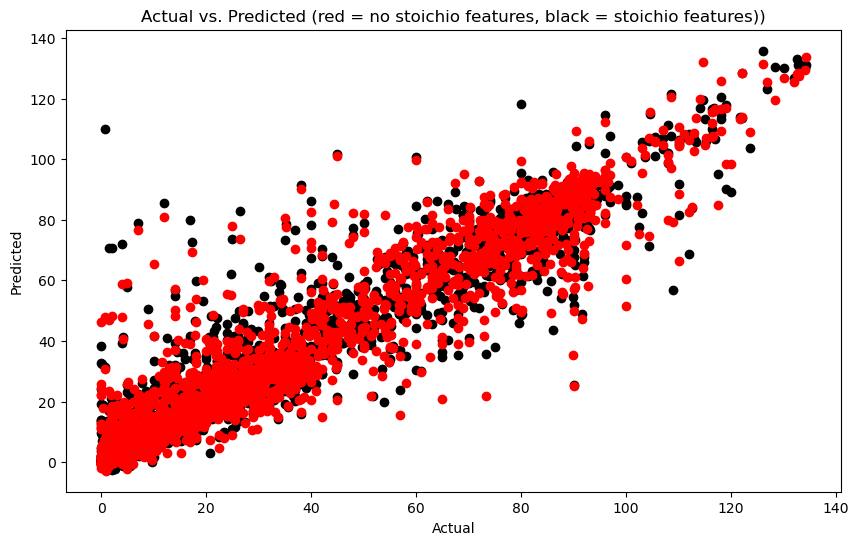

In [55]:
# Create a scatterplot of the actual versus predicted values
plt.figure(figsize=(10, 6))
plt.scatter(XGB_stoichio_y_test, XGB_stoichio_y_pred, color='k')
plt.scatter(XGB_nostoichio_y_test, XGB_nostoichio_y_pred, color='r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted (red = no stoichio features, black = stoichio features))')
plt.show()

In [56]:
# Code to find the top 20 materials with the largest absolute difference between actual and predicted Tc values
# We have XGB_stoichio_mse, XGB_stoichio_r2, XGB_stoichio_y_test, XGB_stoichio_y_pred, XGB_stoichio_model, XGB_stoichio_X_train, XGB_stoichio_X_test

# Calculate the absolute difference between actual and predicted Tc values
differences = np.abs(XGB_nostoichio_y_test - XGB_nostoichio_y_pred)

# Sort the differences in descending order and get the indices of the sorted array
sorted_indices = np.argsort(differences)[::-1]

# Find the corresponding second value of XGB_stoichio_X_test for each top material
materials = [XGB_nostoichio_X_test[i, 0] for i in sorted_indices[:20]]
y_preds = [XGB_nostoichio_y_pred[i] for i in sorted_indices[:20]]
y_tests = [XGB_nostoichio_y_test[i] for i in sorted_indices[:20]]

# Print the materials with their corresponding second values of XGB_stoichio_X_test
print(differences)
for material, y_preds, y_tests in zip(materials, y_preds, y_tests):
    print(f"Material: {material}, prediction: {y_preds}, real: {y_tests}")

[3.31571417 1.34380798 1.42833717 ... 0.74238663 3.21793989 2.76299734]
Material: Ge0.3Cu0.7Sr2Ca3Cu4O11.05, prediction: 76.75198364257812, real: 7.0
Material: Hg0.75Mo0.25Ba2Cu1O4.59, prediction: 80.9782485961914, real: 12.0
Material: Ca1La1Ba1Cu2.8P0.2O7, prediction: 25.121875762939453, real: 90.0
Material: Bi1.6Pb0.4Sr2Cu3Ca2O10.04, prediction: 100.99771118164062, real: 45.0
Material: Ba1.6Sr0.4Yb1Cu3O6.48, prediction: 65.38273620605469, real: 10.0
Material: Ba1, prediction: 58.67644119262695, real: 4.04375
Material: Y1Ba2Cu2.98Zr0.2O6.75, prediction: 35.31208038330078, real: 89.8
Material: Tl1Sr1.5Ce0.5Ca1Cu2O7, prediction: 58.9843635559082, real: 5.0
Material: Bi1.64Pb0.36Sr2Ca0.67Y0.33Cu2O8+z, prediction: 78.0728988647461, real: 25.0
Material: Sr2Ca3Cu4F2O8.6, prediction: 90.09024047851562, real: 38.0
Material: Bi2Sr2Ca0.75La0.25Cu2O8+Z, prediction: 69.45067596435547, real: 17.4
Material: Y1Ba2Cu285Ni0.15O7-z, prediction: 21.698225021362305, real: 73.4
Material: Cu0.5S0.5Sr2Ca2Cu

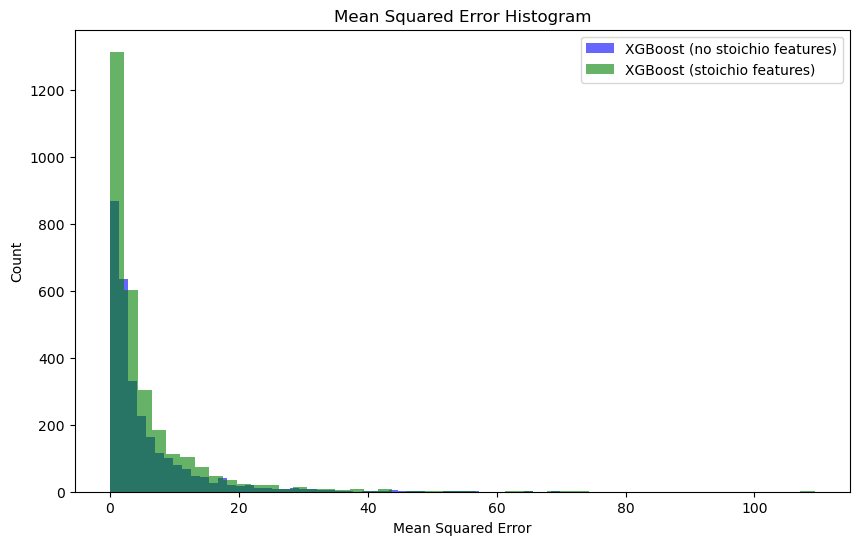

In [57]:
# Plot a histogram of the root mean squared error for each datapoint
plt.figure(figsize=(10, 6))
plt.hist(np.sqrt((XGB_nostoichio_y_test - XGB_nostoichio_y_pred)**2), bins=50, color='blue', alpha=0.6, label='XGBoost (no stoichio features)')
plt.hist(np.sqrt((XGB_stoichio_y_test - XGB_stoichio_y_pred)**2), bins=50, color='green', alpha=0.6, label='XGBoost (stoichio features)')
plt.legend(loc='upper right')
plt.xlabel('Mean Squared Error')
plt.ylabel('Count')
plt.title('Mean Squared Error Histogram')
plt.show()


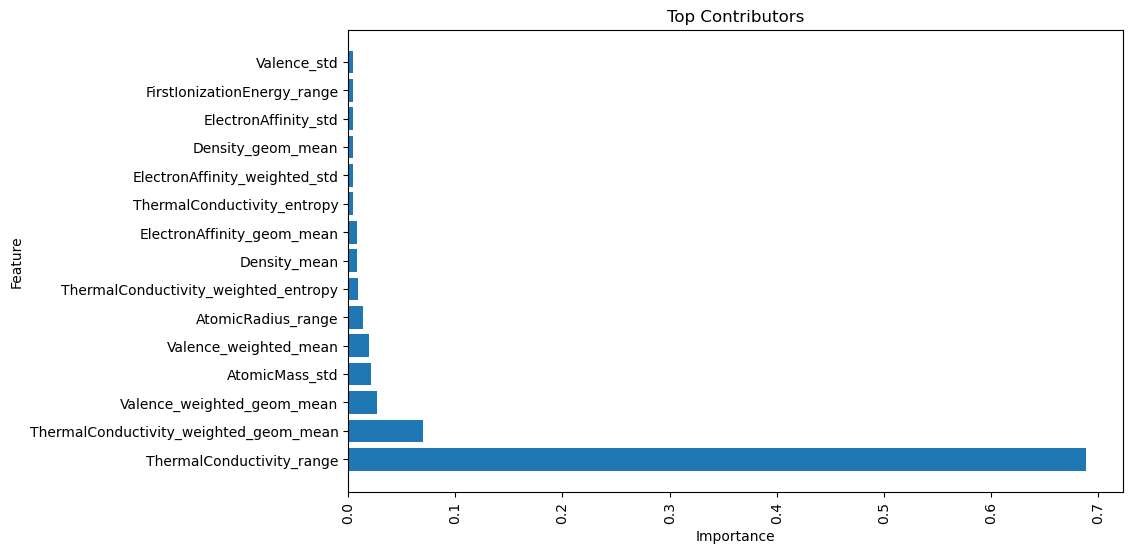

In [58]:
# Plot the feature importances of the model
# Get feature importances
importance = XGB_nostoichio_model.feature_importances_

# Get the column names of the selected features
feature_columns_stoichio = df_for_model.columns[8:]
feature_columns_nostoichio = df_for_model.columns[85:]


# Create a DataFrame to store feature importances with column names
feature_importances = pd.DataFrame({'Feature': feature_columns_nostoichio, 'Importance': importance})

# Sort the DataFrame by importance in descending order
sorted_feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the top contributors
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_importances.head(15)['Feature'], sorted_feature_importances.head(15)['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Contributors')
plt.xticks(rotation=90)
plt.show()

In [60]:
# Spaghetti code to think about what model is predicting to be high-Tc outside of cuprates...
# Of the materials for which we predict > 30K, which ones don't contain Cu or O? Are our predictions off for those?
# value-index 8 and 17 is O and Cu

indices = np.where(XGB_stoichio_y_pred > 30)[0]

highTc_nocuprates = []
highTc_nocuprates_bad_prediction = []

highTc_cuprates = []
highTc_cuprates_bad_prediction = []


for i in indices:
    if np.isnan(XGB_stoichio_X_test[i, 8]) and np.isnan(XGB_stoichio_X_test[i, 17]):
        tup = []
        tup.append(XGB_stoichio_X_test[i, 1])
        tup.append(i)
        highTc_nocuprates.append(tup)

        if XGB_stoichio_y_test[i] > 30:
            tup = []
            tup.append(XGB_stoichio_X_test[i, 1])
            tup.append(i)
            highTc_nocuprates_bad_prediction.append(tup)
    else:
        tup = []
        tup.append(XGB_stoichio_X_test[i, 1])
        tup.append(i)
        highTc_cuprates.append(tup)

        if XGB_stoichio_y_test[i] > 30:
            tup = []
            tup.append(XGB_stoichio_X_test[i, 1])
            tup.append(i)
            highTc_cuprates_bad_prediction.append(tup)

    

print(f'There are {len(indices)} 30K+ superconductors. The following are cuprates vs non cuprate high-Tc predicted superconductors in test set:')
print(len(highTc_nocuprates))
print(len(highTc_nocuprates_bad_prediction))
print(len(highTc_cuprates))
print(len(highTc_cuprates_bad_prediction))
# Return a list of only the sublists between the two lists that aren't in both lists

def find_list_difference(l1, l2):
    return [sub_list for sub_list in l1 if sub_list not in l2] + [sub_list for sub_list in l2 if sub_list not in l1]

bad_prediction_list = find_list_difference(highTc_nocuprates, highTc_nocuprates_bad_prediction)
print(bad_prediction_list)
l2 = []
l3 = []
for l1 in bad_prediction_list:
    l2.append(XGB_stoichio_y_test[l1[1]])
    l3.append(XGB_stoichio_y_pred[l1[1]])

for i in range(7):
    print(bad_prediction_list[i][0])
    print('Experimental Tc: '+ str(l2[i]))
    print('Prediction Tc: ' + str(l3[i]))
    print()

There are 966 30K+ superconductors. The following are cuprates vs non cuprate high-Tc predicted superconductors in test set:
47
40
919
825
[['Rb1', 686], ['Mg0.79Al0.21B2', 694], ['H4Si1', 1095], ['Cs1', 1113], ['Mg0.7Al0.15Li0.15B2', 1705], ['Ba1', 2449], ['Ba0.737K0.263Fe2As2', 2518]]
Rb1
Experimental Tc: 2.1
Prediction Tc: 70.53202

Mg0.79Al0.21B2
Experimental Tc: 27.1
Prediction Tc: 30.854818

H4Si1
Experimental Tc: 17.0
Prediction Tc: 79.913376

Cs1
Experimental Tc: 1.5
Prediction Tc: 70.7462

Mg0.7Al0.15Li0.15B2
Experimental Tc: 27.4
Prediction Tc: 30.77209

Ba1
Experimental Tc: 4.04375
Prediction Tc: 72.12001

Ba0.737K0.263Fe2As2
Experimental Tc: 24.0
Prediction Tc: 30.205153



Plot a correlation matrix between our features:

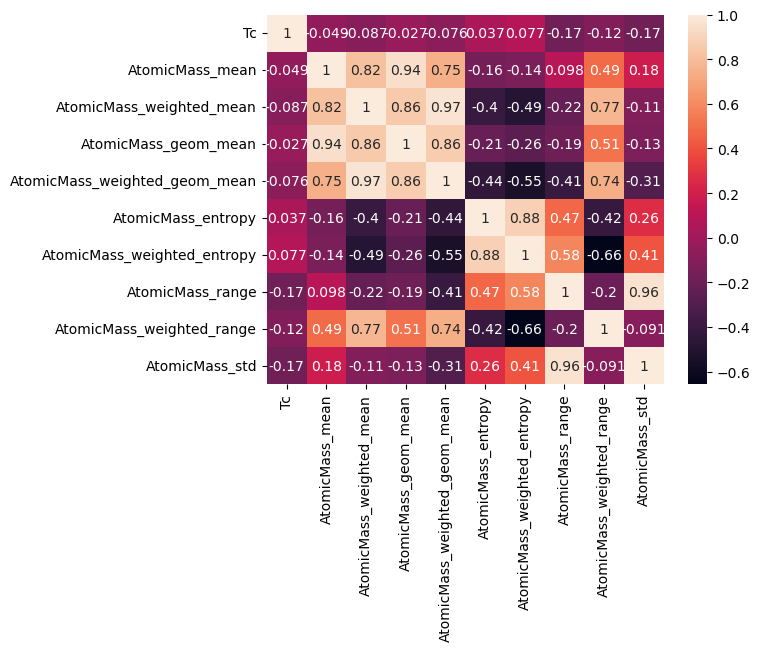

In [61]:

df_for_corr = df_for_model.iloc[:, list(range(84, 94))]
corr_matrix = df_for_corr.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

Neural network model without optimizing:

In [68]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [173]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error, r2_score

def train_evaluate_nn_regression_model(X, y, start_feature_index, epochs=100):

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)
    
    # Take only the features, not the ID columns
    X_train_2 = X_train[:, start_feature_index:].astype('float32')
    X_test_2 = X_test[:, start_feature_index:].astype('float32')

    # Convert nan values - makes sense since elements not in a material are 0, not nan
    X_train_2[np.isnan(X_train_2)] = 0.0
    X_test_2[np.isnan(X_test_2)] = 0.0

    # Standardize the features
    scaler = StandardScaler()
    X_train_2 = scaler.fit_transform(X_train_2)
    X_test_2 = scaler.transform(X_test_2)

    # Define a model
    model = keras.Sequential([
        keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train_2.shape[1],)),
        keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        keras.layers.Dense(1)
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model
    model.fit(X_train_2, y_train, epochs=epochs, batch_size=16)

    # Make predictions on the test set
    y_pred = model.predict(X_test_2)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2, y_test, y_pred, model, X_train, X_test

X0 = df_for_model.iloc[:, [1, 2, 3, 4] + list(range(8, df_for_model.shape[1]))].values
X1 = df_for_model.iloc[:, [1, 2, 3, 4] + list(range(85, df_for_model.shape[1]))].values

# NN_stoichio_mse, NN_stoichio_r2, NN_stoichio_y_test, NN_stoichio_y_pred, NN_stoichio_model, NN_stoichio_X_train, NN_stoichio_X_test = train_evaluate_nn_regression_model(X0, y, 4)
NN_nostoichio_mse, NN_nostoichio_r2, NN_nostoichio_y_test, NN_nostoichio_y_pred, NN_nostoichio_model, NN_nostoichio_X_train, NN_nostoichio_X_test = train_evaluate_nn_regression_model(X1, y, 4)

print("Neural Network (with stoichio features):")
#print("MSE:", NN_stoichio_mse)
#print("R2 Score:", NN_stoichio_r2)

print("Neural Network (without stoichio features):")
print("MSE:", NN_nostoichio_mse)
print("R2 Score:", NN_nostoichio_r2)


Epoch 1/100
729/729 [==============================] - 2s 2ms/step - loss: 379.6914
Epoch 2/100
729/729 [==============================] - 1s 1ms/step - loss: 243.0665
Epoch 3/100
729/729 [==============================] - 1s 1ms/step - loss: 228.3312
Epoch 4/100
729/729 [==============================] - 1s 1ms/step - loss: 219.2300
Epoch 5/100
729/729 [==============================] - 1s 1ms/step - loss: 209.0600
Epoch 6/100
729/729 [==============================] - 1s 2ms/step - loss: 204.6103
Epoch 7/100
729/729 [==============================] - 1s 2ms/step - loss: 200.5376
Epoch 8/100
729/729 [==============================] - 1s 2ms/step - loss: 191.4106
Epoch 9/100
729/729 [==============================] - 1s 1ms/step - loss: 187.8114
Epoch 10/100
729/729 [==============================] - 1s 1ms/step - loss: 182.3213
Epoch 11/100
729/729 [==============================] - 1s 1ms/step - loss: 178.6714
Epoch 12/100
729/729 [==============================] - 2s 2ms/step - loss

In [188]:
#Feature importances acting strange. Need to fix.

# import matplotlib.pyplot as plt

# # Get the first layer weights (input layer to the first hidden layer)
# weights_first_layer = NN_nostoichio_model.layers[0].get_weights()[0]

# # Calculate the feature importances as the absolute values of the weights
# feature_importances = np.abs(weights_first_layer).mean(axis=1)

# # Sort the feature importances in descending order
# sorted_indices = np.argsort(feature_importances)[::-1]
# sorted_importances = feature_importances[sorted_indices]

# # Get the corresponding feature names
# # Assuming df_for_model is your DataFrame
# feature_names = df_for_model.iloc[:, [1, 2, 3, 4] + list(range(8, df_for_model.shape[1]))].columns[4+sorted_indices]

# # Plot the feature importances
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(sorted_importances)), sorted_importances)
# plt.xticks(range(len(sorted_importances)), feature_names, rotation=90)
# plt.xlabel('Features')
# plt.ylabel('Feature Importances')
# plt.title('Feature Importances from Neural Network Model')
# plt.tight_layout()
# plt.show()


In [ ]:
# Terrible way of being able to see the formula a guess and the real Tc
# X = updated_df.iloc[14100:14150,8:].values
# y = updated_df.iloc[14100:14150]['average_Tc'].values
# names = updated_df.iloc[14100:14150]['supercon_formula'].values
#
# predictions = model.predict(X)
# #
#
# for i, prediction in enumerate(predictions):
#    print(f"Formula: {names[i]}, Predicted Tc: {prediction}, Real Tc: {y[i]}")

In [ ]:
# # 30m runtime !!! This was an old way with more loops to make features like below.

# from numpy.ma.core import mean
# from scipy.stats import gmean, entropy
# from statsmodels.stats.weightstats import DescrStatsW

# # We are going to create a 3D space (np array) with coordinates (feature, property, material_name)

# data = np.empty((len(df_used),30,10), dtype=object)
# data.fill(None)

# # Iterate over every *material*
# for material_index, row in df_used.iterrows():


#   # NEXT TWO LINES CONTAIN MAGIC NUMBERS
#   # Get the total number of atoms in a material.
#   n_atoms = np.nansum(row[8:])

#   # get a series object of all the elements and how there are in the mat.
#   elem_row = row[8:]

#   # Create a Boolean mask for non-null entries
#   mask = elem_row.notna()

#   # Get intermediate variables to calculate features ---
#   atom_name_list = []
#   p_list = []

#   for index1, value1 in elem_row[mask].iteritems():
#     atom_name_list.append(index1)
#     p_list.append(value1 / n_atoms)


#   # Iterate over every *property*
#   for property_index, property_name in enumerate(element_data.columns[1:31]):

#     t_list = []

#     # Go through the atoms
#     for index2, value2 in elem_row[mask].items():

#       # Extract the value of the property
#       property_value = element_data[element_data['Element'] == index2][property_name].values[0]
#       #print(property_value)

#       # Append the property value to t_list
#       t_list.append(property_value)

#     p_list = np.array(p_list)
#     t_list = np.array(t_list)
#     print(t_list)
#     w_list = t_list / np.sum(t_list) # Could be wrong
#     capital_list = np.multiply(p_list, w_list) / np.sum(np.multiply(p_list, w_list))


#     # Add into our *3D-magic-thing* this coordinate.
#     data[material_index][property_index][0] = np.mean(t_list)
#     data[material_index][property_index][1] = DescrStatsW(t_list, weights=p_list).mean
#     data[material_index][property_index][2] = gmean(t_list)
#     data[material_index][property_index][3] = gmean(t_list, weights=p_list)
#     data[material_index][property_index][4] = entropy(w_list)
#     data[material_index][property_index][5] = entropy(capital_list)
#     data[material_index][property_index][6] = np.ptp(t_list)
#     data[material_index][property_index][7] = np.ptp(np.multiply(t_list, p_list))
#     data[material_index][property_index][8] = np.std(t_list)
#     data[material_index][property_index][9] = DescrStatsW(t_list, weights=p_list).std